<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesores: Ignacio Meza, Sebastián Tinoco
- Auxiliares: Catherine Benavides y Consuelo Rojas
- Ayudante: Nicolás Ojeda, Eduardo Moya

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Benjamín Aguilar.
- Nombre de alumno 2: Sebastián Vásquez.


### Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

### Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.
- Código que no se pueda ejecutar, no será revisado.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `http://....`

# Importamos librerias útiles

In [85]:
!pip install -qq xgboost optuna

# El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'])

df.head()

/tmp/ipykernel_10010/3184305967.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'])


,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,0,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,glass,500ml,0.96,13280
1,1,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,plastic,1.5lt,2.86,6727
2,2,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,kinder-cola,can,330ml,0.87,9848
3,3,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,glass,500ml,1.00,20050
4,4,2012-01-31,Athens,37.97945,23.71622,672130,shop_1,adult-cola,can,330ml,0.39,25696


## 1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

In [3]:
# Inserte su código acá
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
SEED = 40
#1
X_train,X_aux,y_train,y_aux= train_test_split(df.loc[:, df.columns != 'quantity'],df.loc[:,"quantity"],test_size=0.3,random_state=SEED)
X_val,X_test,y_val,y_test = train_test_split(X_aux,y_aux,test_size=0.33,random_state=SEED)

#y_train = 
#2
def transform_date(X):
    X["day"] = X.date.apply(lambda x: x.day).astype("category")
    X["month"] = X.date.apply(lambda x: x.month).astype("category")
    X["year"] = X.date.apply(lambda x: x.year).astype("category")
    return X.loc[:,X.columns!='date']

extract_fun = FunctionTransformer(transform_date)
#3
col_transformer = ColumnTransformer([("one_hot_encoder",OneHotEncoder(sparse_output=False,handle_unknown='ignore'),["day","month","year","shop","brand","container","capacity","lat"]),
                                     ("min_max_scaler",MinMaxScaler(),["price"])], remainder="drop")

col_transformer.set_output(transform='pandas')
#4
pipeline_dummy = Pipeline([("modify_date",extract_fun),
                     ("col_transformer",col_transformer),
                     ("regressor",DummyRegressor(strategy="mean"))])

In [4]:
#5
pipeline_dummy.fit(X_train,y_train)
mean_absolute_error(y_val,pipeline_dummy.predict(X_val))

13688.153453119203

Esto quiere decir que de media se está prediciendo que la demanda es o 13688 más que el valor real o 13688 menos que el valor real. Esto claramente es malo en el contexto de negocio, pues el vendedor estaría teniendo o demaciada mercadería o muy poca, lo cual puede provocar el no vender todo o vender muy rápido, incurriendo en potenciales pérdidas.

In [5]:
#6
from xgboost import XGBRegressor
pipeline_xgb = Pipeline(pipeline_dummy.steps[:-1]+[('regressor',XGBRegressor(random_state=SEED))])
pipeline_xgb.fit(X_train,y_train)
mean_absolute_error(y_val,pipeline_xgb.predict(X_val))

2379.745959619336

Mejora bastante el MAE al utilizar XGBRegressor, lo cual es normal, pues logra captar y aprender de cierta manera el ajuste de los datos.

In [6]:
#7
import pickle
pickle.dump(pipeline_dummy["regressor"],open('dummy.pkl','wb'))
pickle.dump(pipeline_xgb["regressor"],open('xgb.pkl','wb'))

## 2. Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo realizando las siguientes tareas:

1. Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Para aplicar esta restricción apóyese en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>. Hint: Para implementar el constraint se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

2. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación.

3. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?




In [7]:
# Inserte su código acá

pipeline_xgb_wconstraints = Pipeline([pipeline_xgb.steps[0],pipeline_xgb.steps[1],("regressor",XGBRegressor(monotone_constraints={"min_max_scaler__price":-1}))])

In [8]:
pipeline_xgb_wconstraints.fit(X_train,y_train)

Pipeline(steps=[('modify_date',
                 FunctionTransformer(func=<function transform_date at 0x7f0251dc4040>)),
                ('col_transformer',
                 ColumnTransformer(transformers=[('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['day', 'month', 'year',
                                                   'shop', 'brand', 'container',
                                                   'capacity', 'lat']),
                                                 ('min_max_scaler',
                                                  MinMaxScaler(),
                                                  ['price'])])),
                ('regre...
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints={'min_max_scaler__price': -1},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [9]:
mean_absolute_error(y_val,pipeline_xgb_wconstraints.predict(X_val))

2438.5056939322417

En este caso empeora el resultado, sin embargo, esto no quiere decir que el amigo no tenía razón, pues, tal como se ve en el gráfico desplegado, esa tendencia es real, sin embargo, esto no implica que se obtengan resultados más óptimos sobre un conjunto que el regresor nunca ha visto.

Text(0, 0.5, 'quantity')

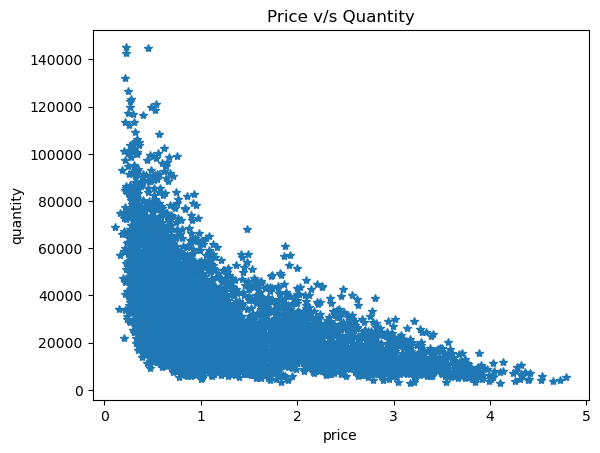

In [10]:
from matplotlib import pyplot as plt
plt.plot(df.price,df.quantity,'*')
plt.title("Price v/s Quantity")
plt.xlabel("price")
plt.ylabel("quantity")

## 3. Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

In [12]:
# Inserte su código acá
import optuna
from optuna.samplers import TPESampler
def objective_function(trial):
    X_train,X_aux,y_train,y_aux= train_test_split(df.loc[:, df.columns != 'quantity'],df.loc[:,"quantity"],test_size=0.3,random_state=SEED)
    X_val,X_test,y_val,y_test = train_test_split(X_aux,y_aux,test_size=0.33,random_state=SEED)

    params_xgb = {

        "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
        "n_estimators": trial.suggest_int("n_estimators",50,1000),
        "max_depth": trial.suggest_int("max_depth",3,10),
        "max_leaves": trial.suggest_int("max_leaves",0,100),
        "min_child_weight": trial.suggest_int("min_child_weight",1,5),
        "reg_alpha": trial.suggest_float("reg_alpha",0,1),
        "reg_lambda": trial.suggest_float("reg_lambda",0,1)
    }
    params_one_hot_encoder = {"sparse_output":False,
                              "handle_unknown":"ignore",
        "min_frequency":trial.suggest_float("min_frequency",0,1)}

    extract_fun = FunctionTransformer(transform_date)
    col_transformer = ColumnTransformer([("one_hot_encoder",OneHotEncoder(**params_one_hot_encoder),["day","month","year","shop","brand","container","capacity","lat"]),
                                     ("min_max_scaler",MinMaxScaler(),["price"])], remainder="drop")
    pipeline_to_optimize = Pipeline([("date_fun",extract_fun),("col_transformer",col_transformer),("regressor",XGBRegressor(seed=SEED,**params_xgb))])
    pipeline_to_optimize.fit(X_train,y_train)

    yhat = pipeline_to_optimize.predict(X_val)
    return mean_absolute_error(y_val,yhat)
study = optuna.create_study(direction="minimize",sampler=TPESampler())
study.optimize(objective_function,timeout=300)


[I 2024-06-02 22:18:12,289] A new study created in memory with name: no-name-f55b9275-a724-4cd7-a029-f4d897511d49
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:12,470] Trial 0 finished with value: 10618.162431418976 and parameters: {'learning_rate': 0.03959813669820221, 'n_estimators': 776, 'max_depth': 4, 'max_leaves': 67, 'min_child_weight': 2, 'reg_alpha': 0.1590374063822314, 'reg_lambda': 0.8269131585904903, 'min_frequency': 0.44241063553758886}. Best is trial 0 with value: 10618.162431418976.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use s

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:15,417] Trial 12 finished with value: 2176.678218581807 and parameters: {'learning_rate': 0.08363065003856035, 'n_estimators': 990, 'max_depth': 8, 'max_leaves': 37, 'min_child_weight': 1, 'reg_alpha': 0.6576368535678664, 'reg_lambda': 0.004728531629982907, 'min_frequency': 0.014994320373733883}. Best is trial 11 with value: 2104.5618322802798.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:18:20,053] Trial 24 finished with value: 9032.574533948911 and parameters: {'learning_rate': 0.027692603178824753, 'n_estimators': 933, 'max_depth': 7, 'max_leaves': 20, 'min_child_weight': 1, 'reg_alpha': 0.5318172384060241, 'reg_lambda': 0.1813301511717842, 'min_frequency': 0.2629953682366672}. Best is trial 21 with value: 2100.9251190715227.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:20,621] Trial 25 finished with value: 4027.7565186198785 and parameters: {'learning_rate': 0.06647461764810951, 'n_estimators': 817, 'max_depth': 10, 'max_leaves': 66, 'min_child_weight': 2, 'reg_alpha': 0.8144924305264087, 'reg_lambda': 0.12106564755827509, 'min_frequency': 0.08234139041153414}. Be

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:25,055] Trial 37 finished with value: 5780.105594894755 and parameters: {'learning_rate': 0.048474705906731266, 'n_estimators': 225, 'max_depth': 9, 'max_leaves': 34, 'min_child_weight': 1, 'reg_alpha': 0.7503721665181455, 'reg_lambda': 0.6726554742673381, 'min_frequency': 0.14368169048664298}. Best is trial 21 with value: 2100.9251190715227.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 

[I 2024-06-02 22:18:29,863] Trial 49 finished with value: 10767.092081760054 and parameters: {'learning_rate': 0.040884520259343395, 'n_estimators': 955, 'max_depth': 10, 'max_leaves': 36, 'min_child_weight': 1, 'reg_alpha': 0.6098301153141773, 'reg_lambda': 0.3297604175752018, 'min_frequency': 0.38541281284035095}. Best is trial 41 with value: 2080.0395224231265.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:30,133] Trial 50 finished with value: 9274.711775205482 and parameters: {'learning_rate': 0.059168292225958805, 'n_estimators': 881, 'max_depth': 9, 'max_leaves': 26, 'min_child_weight': 1, 'reg_alpha': 0.4438124430032794, 'reg_lambda': 0.10321895603252079, 'min_frequency': 0.2279293077270962}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:35,512] Trial 62 finished with value: 2107.5655680555847 and parameters: {'learning_rate': 0.0988441220402977, 'n_estimators': 849, 'max_depth': 10, 'max_leaves': 37, 'min_child_weight': 1, 'reg_alpha': 0.7310945988846982, 'reg_lambda': 0.19198241726353416, 'min_frequency': 0.032646926676549705}. Best is trial 41 with value: 2080.0395224231265.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:18:41,578] Trial 74 finished with value: 6518.8994209075645 and parameters: {'learning_rate': 0.06667154552942064, 'n_estimators': 883, 'max_depth': 7, 'max_leaves': 76, 'min_child_weight': 1, 'reg_alpha': 0.6637332109922228, 'reg_lambda': 0.02734115969621298, 'min_frequency': 0.1487886800916121}. Best is trial 64 with value: 2076.590200345252.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:42,121] Trial 75 finished with value: 2191.792172603836 and parameters: {'learning_rate': 0.05089930731061884, 'n_estimators': 909, 'max_depth': 9, 'max_leaves': 65, 'min_child_weight': 1, 'reg_alpha': 0.6068332739849746, 'reg_lambda': 0.13056269656343283, 'min_frequency': 0.019894623614363963}. Bes

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:47,038] Trial 87 finished with value: 6210.095534280082 and parameters: {'learning_rate': 0.06541808841166122, 'n_estimators': 378, 'max_depth': 10, 'max_leaves': 87, 'min_child_weight': 1, 'reg_alpha': 0.8093401479164399, 'reg_lambda': 0.2258240824285325, 'min_frequency': 0.11294254046347983}. Best is trial 80 with value: 2050.662449509502.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2

[I 2024-06-02 22:18:52,733] Trial 99 finished with value: 6730.90155021148 and parameters: {'learning_rate': 0.07079340874384457, 'n_estimators': 802, 'max_depth': 10, 'max_leaves': 95, 'min_child_weight': 1, 'reg_alpha': 0.5787256402417883, 'reg_lambda': 0.20088866468445035, 'min_frequency': 0.10399027739955877}. Best is trial 80 with value: 2050.662449509502.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:53,303] Trial 100 finished with value: 2102.122268493408 and parameters: {'learning_rate': 0.09237378802506006, 'n_estimators': 872, 'max_depth': 9, 'max_leaves': 87, 'min_child_weight': 1, 'reg_alpha': 0.5455618673214859, 'reg_lambda': 0.7145829961387419, 'min_frequency': 0.03169247026223048}. Best

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:18:59,827] Trial 112 finished with value: 2143.5222583561936 and parameters: {'learning_rate': 0.09258628101234892, 'n_estimators': 912, 'max_depth': 7, 'max_leaves': 92, 'min_child_weight': 1, 'reg_alpha': 0.5935107888303102, 'reg_lambda': 0.8544957570313699, 'min_frequency': 0.008021840474172634}. Best is trial 80 with value: 2050.662449509502.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:19:06,009] Trial 124 finished with value: 10623.337432005696 and parameters: {'learning_rate': 0.09070359176961108, 'n_estimators': 849, 'max_depth': 6, 'max_leaves': 88, 'min_child_weight': 3, 'reg_alpha': 0.6485969850597821, 'reg_lambda': 0.7529553536072913, 'min_frequency': 0.962882101148138}. Best is trial 118 with value: 2049.285554730526.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:06,388] Trial 125 finished with value: 2232.4249269207903 and parameters: {'learning_rate': 0.06902088893311736, 'n_estimators': 831, 'max_depth': 5, 'max_leaves': 90, 'min_child_weight': 3, 'reg_alpha': 0.6022486445920083, 'reg_lambda': 0.7929682612443475, 'min_frequency': 0.000830691796271512}. Be

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:11,488] Trial 137 finished with value: 2071.537280827562 and parameters: {'learning_rate': 0.08646535631382386, 'n_estimators': 902, 'max_depth': 6, 'max_leaves': 91, 'min_child_weight': 3, 'reg_alpha': 0.6847927943201033, 'reg_lambda': 0.8615095493400758, 'min_frequency': 0.0017972456254735873}. Best is trial 130 with value: 2046.5883820028266.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),


[I 2024-06-02 22:19:16,716] Trial 149 finished with value: 5453.528732483154 and parameters: {'learning_rate': 0.06656955354101637, 'n_estimators': 937, 'max_depth': 6, 'max_leaves': 85, 'min_child_weight': 3, 'reg_alpha': 0.8112536364930314, 'reg_lambda': 0.8141988395761205, 'min_frequency': 0.0862397823853158}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:17,163] Trial 150 finished with value: 2132.2084100415136 and parameters: {'learning_rate': 0.060668383021372854, 'n_estimators': 928, 'max_depth': 6, 'max_leaves': 92, 'min_child_weight': 3, 'reg_alpha': 0.7178582030263481, 'reg_lambda': 0.8526403519349446, 'min_frequency': 0.03202491552566213}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:22,766] Trial 162 finished with value: 2063.8068744980287 and parameters: {'learning_rate': 0.0704488773769228, 'n_estimators': 966, 'max_depth': 6, 'max_leaves': 95, 'min_child_weight': 3, 'reg_alpha': 0.8843721918138605, 'reg_lambda': 0.8926436395485067, 'min_frequency': 0.07236904567845576}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:19:28,192] Trial 174 finished with value: 10623.288176879068 and parameters: {'learning_rate': 0.077424204027461, 'n_estimators': 952, 'max_depth': 6, 'max_leaves': 95, 'min_child_weight': 3, 'reg_alpha': 0.7573415152098016, 'reg_lambda': 0.7229243098778628, 'min_frequency': 0.7755601141101599}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:28,624] Trial 175 finished with value: 2083.6923112652808 and parameters: {'learning_rate': 0.0652186924506013, 'n_estimators': 978, 'max_depth': 6, 'max_leaves': 93, 'min_child_weight': 3, 'reg_alpha': 0.8157493829357374, 'reg_lambda': 0.7718545811090995, 'min_frequency': 0.021437551634129227}. Bes

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:34,596] Trial 187 finished with value: 5935.6831123138145 and parameters: {'learning_rate': 0.004916030002222074, 'n_estimators': 974, 'max_depth': 6, 'max_leaves': 98, 'min_child_weight': 3, 'reg_alpha': 0.9822156434136006, 'reg_lambda': 0.9233360907294216, 'min_frequency': 0.1291878817249632}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:40,112] Trial 199 finished with value: 2087.9061797566023 and parameters: {'learning_rate': 0.09142270509072555, 'n_estimators': 934, 'max_depth': 6, 'max_leaves': 89, 'min_child_weight': 3, 'reg_alpha': 0.8598287754352419, 'reg_lambda': 0.7436878584637601, 'min_frequency': 0.02925522694565314}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:45,379] Trial 211 finished with value: 2085.9767848016104 and parameters: {'learning_rate': 0.08467619723881717, 'n_estimators': 984, 'max_depth': 6, 'max_leaves': 87, 'min_child_weight': 3, 'reg_alpha': 0.7079389199158471, 'reg_lambda': 0.6549998597910673, 'min_frequency': 0.03864336122527748}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:51,596] Trial 223 finished with value: 2100.805787110679 and parameters: {'learning_rate': 0.08695507441182893, 'n_estimators': 929, 'max_depth': 6, 'max_leaves': 83, 'min_child_weight': 3, 'reg_alpha': 0.7306194823861829, 'reg_lambda': 0.7513708313900876, 'min_frequency': 0.018428160493244215}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:19:56,716] Trial 235 finished with value: 2076.73338344355 and parameters: {'learning_rate': 0.0904575332368266, 'n_estimators': 959, 'max_depth': 6, 'max_leaves': 80, 'min_child_weight': 3, 'reg_alpha': 0.7475543873871924, 'reg_lambda': 0.756426079548978, 'min_frequency': 0.01569088979267916}. Best is trial 140 with value: 2018.6358114530312.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:19:57,161] Trial 236 finished with value: 2060.619020021487 and parameters: {'learning_rate': 0.07601798241264858, 'n_estimators': 997, 'max_depth': 6, 'max_leaves': 89, 'min_child_weight': 3, 'reg_alpha': 0.8103785506902732, 'reg_lambda': 0.7240638262793426, 'min_frequency': 0.04242179876724166}. Best 

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:02,624] Trial 248 finished with value: 2057.3274510871265 and parameters: {'learning_rate': 0.0971732113160706, 'n_estimators': 894, 'max_depth': 6, 'max_leaves': 76, 'min_child_weight': 3, 'reg_alpha': 0.7528933648954839, 'reg_lambda': 0.6793781596377063, 'min_frequency': 0.057564674246279326}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:20:07,789] Trial 260 finished with value: 9286.333174701685 and parameters: {'learning_rate': 0.08146189708509562, 'n_estimators': 885, 'max_depth': 6, 'max_leaves': 80, 'min_child_weight': 3, 'reg_alpha': 0.7405430991076197, 'reg_lambda': 0.6993543514439156, 'min_frequency': 0.30138637785487077}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:08,292] Trial 261 finished with value: 5947.399726001857 and parameters: {'learning_rate': 0.017111290739397416, 'n_estimators': 913, 'max_depth': 7, 'max_leaves': 83, 'min_child_weight': 3, 'reg_alpha': 0.6601875301679558, 'reg_lambda': 0.7366268045367748, 'min_frequency': 0.08875520617824761}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:13,198] Trial 273 finished with value: 2035.3714125344209 and parameters: {'learning_rate': 0.09186998124647024, 'n_estimators': 855, 'max_depth': 6, 'max_leaves': 79, 'min_child_weight': 3, 'reg_alpha': 0.7448507547504324, 'reg_lambda': 0.6311883619891265, 'min_frequency': 0.06831157565709224}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:18,633] Trial 285 finished with value: 2062.785069382875 and parameters: {'learning_rate': 0.09242548312424331, 'n_estimators': 899, 'max_depth': 6, 'max_leaves': 77, 'min_child_weight': 3, 'reg_alpha': 0.35158710517317254, 'reg_lambda': 0.6836070853845138, 'min_frequency': 0.07757954287778451}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:20:23,556] Trial 297 finished with value: 2116.341146756874 and parameters: {'learning_rate': 0.09944681171041514, 'n_estimators': 599, 'max_depth': 6, 'max_leaves': 87, 'min_child_weight': 3, 'reg_alpha': 0.7715729777259651, 'reg_lambda': 0.6601810100818242, 'min_frequency': 0.015555229070099198}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:24,032] Trial 298 finished with value: 6438.2332343189355 and parameters: {'learning_rate': 0.08493569737959764, 'n_estimators': 962, 'max_depth': 6, 'max_leaves': 81, 'min_child_weight': 3, 'reg_alpha': 0.7080401996153601, 'reg_lambda': 0.6906918266533357, 'min_frequency': 0.11270586107030156}. 

[I 2024-06-02 22:20:29,180] Trial 309 finished with value: 2111.791896519578 and parameters: {'learning_rate': 0.07180348004573091, 'n_estimators': 828, 'max_depth': 6, 'max_leaves': 81, 'min_child_weight': 3, 'reg_alpha': 0.6532197034959804, 'reg_lambda': 0.8212053943770363, 'min_frequency': 0.019592849747599964}. Best is trial 239 with value: 2009.6368321824934.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:29,591] Trial 310 finished with value: 2098.184374902213 and parameters: {'learning_rate': 0.08312149835905476, 'n_estimators': 880, 'max_depth': 6, 'max_leaves': 83, 'min_child_weight': 3, 'reg_alpha': 0.711584122570492, 'reg_lambda': 0.5700311674602901, 'min_frequency': 0.02149880020389945}. Be

[I 2024-06-02 22:20:34,021] Trial 321 finished with value: 2069.8363426626124 and parameters: {'learning_rate': 0.07761096579951256, 'n_estimators': 900, 'max_depth': 6, 'max_leaves': 79, 'min_child_weight': 3, 'reg_alpha': 0.7085512291063624, 'reg_lambda': 0.8618060101070728, 'min_frequency': 0.02845544356800824}. Best is trial 317 with value: 2004.8179155866676.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:34,120] Trial 322 finished with value: 3536.9928641834945 and parameters: {'learning_rate': 0.08318894576924171, 'n_estimators': 55, 'max_depth': 6, 'max_leaves': 84, 'min_child_weight': 3, 'reg_alpha': 0.7266957396218849, 'reg_lambda': 0.7579664723213192, 'min_frequency': 0.01938541359181703}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:39,709] Trial 334 finished with value: 6490.168102065775 and parameters: {'learning_rate': 0.09924256364190609, 'n_estimators': 960, 'max_depth': 6, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.709519278894763, 'reg_lambda': 0.7712699817725869, 'min_frequency': 0.09725663063700943}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 

[I 2024-06-02 22:20:44,967] Trial 346 finished with value: 2128.757973847943 and parameters: {'learning_rate': 0.09178740498946819, 'n_estimators': 903, 'max_depth': 6, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.7265776793614406, 'reg_lambda': 0.5063135704258763, 'min_frequency': 0.05192943507812151}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:45,537] Trial 347 finished with value: 2066.2573041724904 and parameters: {'learning_rate': 0.09217596397112027, 'n_estimators': 967, 'max_depth': 6, 'max_leaves': 74, 'min_child_weight': 3, 'reg_alpha': 0.6366975489966563, 'reg_lambda': 0.7879594676531314, 'min_frequency': 0.07504385314706143}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:50,269] Trial 359 finished with value: 3456.748927932556 and parameters: {'learning_rate': 0.005962350164311656, 'n_estimators': 828, 'max_depth': 6, 'max_leaves': 72, 'min_child_weight': 3, 'reg_alpha': 0.7429030053124773, 'reg_lambda': 0.7019543229439358, 'min_frequency': 0.01861673481895875}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:20:56,544] Trial 371 finished with value: 2037.4446677601386 and parameters: {'learning_rate': 0.09079282474588475, 'n_estimators': 846, 'max_depth': 7, 'max_leaves': 83, 'min_child_weight': 3, 'reg_alpha': 0.6812550086249178, 'reg_lambda': 0.8036138865098039, 'min_frequency': 0.03202392185951336}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:01,633] Trial 383 finished with value: 2046.4473335867094 and parameters: {'learning_rate': 0.0910374910316132, 'n_estimators': 983, 'max_depth': 6, 'max_leaves': 77, 'min_child_weight': 3, 'reg_alpha': 0.7570591671088377, 'reg_lambda': 0.7264294465609712, 'min_frequency': 0.022274829040780347}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:21:06,523] Trial 395 finished with value: 2054.611628166983 and parameters: {'learning_rate': 0.08598843651867796, 'n_estimators': 851, 'max_depth': 6, 'max_leaves': 77, 'min_child_weight': 3, 'reg_alpha': 0.4471580021404682, 'reg_lambda': 0.4336152730499433, 'min_frequency': 0.06074763974855304}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:07,028] Trial 396 finished with value: 2019.222465240112 and parameters: {'learning_rate': 0.09183552244687708, 'n_estimators': 911, 'max_depth': 6, 'max_leaves': 86, 'min_child_weight': 3, 'reg_alpha': 0.7463299347444614, 'reg_lambda': 0.6555197630388183, 'min_frequency': 0.0003104002421001717}. 

[I 2024-06-02 22:21:11,756] Trial 407 finished with value: 2113.381277901786 and parameters: {'learning_rate': 0.06453752601369188, 'n_estimators': 881, 'max_depth': 7, 'max_leaves': 84, 'min_child_weight': 3, 'reg_alpha': 0.43053368800911157, 'reg_lambda': 0.807420507599536, 'min_frequency': 0.017196149620444322}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:12,162] Trial 408 finished with value: 2084.898686366979 and parameters: {'learning_rate': 0.09952724776134378, 'n_estimators': 968, 'max_depth': 5, 'max_leaves': 87, 'min_child_weight': 3, 'reg_alpha': 0.7343939001097268, 'reg_lambda': 0.7644493106871758, 'min_frequency': 0.080272999864205}. Bes

[I 2024-06-02 22:21:17,493] Trial 419 finished with value: 6497.997761012079 and parameters: {'learning_rate': 0.08529428529155678, 'n_estimators': 814, 'max_depth': 7, 'max_leaves': 69, 'min_child_weight': 3, 'reg_alpha': 0.32134677932318856, 'reg_lambda': 0.8803475116817969, 'min_frequency': 0.08848928260192994}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:17,951] Trial 420 finished with value: 6022.811503880173 and parameters: {'learning_rate': 0.02554077927185696, 'n_estimators': 839, 'max_depth': 7, 'max_leaves': 73, 'min_child_weight': 3, 'reg_alpha': 0.7938813319663699, 'reg_lambda': 0.8747292308563934, 'min_frequency': 0.12833655281172363}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:23,998] Trial 432 finished with value: 2151.622758241457 and parameters: {'learning_rate': 0.08313160684208724, 'n_estimators': 581, 'max_depth': 6, 'max_leaves': 76, 'min_child_weight': 3, 'reg_alpha': 0.7740462243114116, 'reg_lambda': 0.8189397080087389, 'min_frequency': 0.03192728552382405}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:21:33,150] Trial 444 finished with value: 10778.779968017252 and parameters: {'learning_rate': 0.09381655146540865, 'n_estimators': 924, 'max_depth': 7, 'max_leaves': 80, 'min_child_weight': 3, 'reg_alpha': 0.7551170630363113, 'reg_lambda': 0.7444180317540949, 'min_frequency': 0.45570727740594097}. Best is trial 331 with value: 1995.8584486346379.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:33,500] Trial 445 finished with value: 2109.976754161799 and parameters: {'learning_rate': 0.07219650612963173, 'n_estimators': 728, 'max_depth': 6, 'max_leaves': 82, 'min_child_weight': 3, 'reg_alpha': 0.7744703917041644, 'reg_lambda': 0.3917638058217921, 'min_frequency': 0.017069802285813993}. 

[I 2024-06-02 22:21:40,520] Trial 456 finished with value: 2167.7927827924213 and parameters: {'learning_rate': 0.09970176837618376, 'n_estimators': 955, 'max_depth': 5, 'max_leaves': 91, 'min_child_weight': 3, 'reg_alpha': 0.5067624355311757, 'reg_lambda': 0.6621807756629563, 'min_frequency': 0.03184926040835427}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:41,003] Trial 457 finished with value: 6441.9630364900595 and parameters: {'learning_rate': 0.09193269337675647, 'n_estimators': 914, 'max_depth': 6, 'max_leaves': 85, 'min_child_weight': 3, 'reg_alpha': 0.8176628340282698, 'reg_lambda': 0.6134223892483064, 'min_frequency': 0.10781110668517646}. 

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:47,035] Trial 469 finished with value: 2027.8611472197306 and parameters: {'learning_rate': 0.0920426579431721, 'n_estimators': 939, 'max_depth': 6, 'max_leaves': 78, 'min_child_weight': 2, 'reg_alpha': 0.3842564740606322, 'reg_lambda': 0.5517689887391036, 'min_frequency': 0.04908541642944278}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:21:53,321] Trial 481 finished with value: 2079.4769257773387 and parameters: {'learning_rate': 0.09234470932800441, 'n_estimators': 939, 'max_depth': 7, 'max_leaves': 73, 'min_child_weight': 3, 'reg_alpha': 0.6879612910650673, 'reg_lambda': 0.6582657044597058, 'min_frequency': 0.04724485350739328}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:53,920] Trial 482 finished with value: 2051.4363925663906 and parameters: {'learning_rate': 0.08455787736469354, 'n_estimators': 884, 'max_depth': 7, 'max_leaves': 73, 'min_child_weight': 3, 'reg_alpha': 0.6440416277829384, 'reg_lambda': 0.6972081202947956, 'min_frequency': 0.06736748420725949}. 

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:21:59,838] Trial 494 finished with value: 10777.391228017565 and parameters: {'learning_rate': 0.085211034175046, 'n_estimators': 919, 'max_depth': 6, 'max_leaves': 89, 'min_child_weight': 3, 'reg_alpha': 0.6806151943946926, 'reg_lambda': 0.6743879951437929, 'min_frequency': 0.41225704112715444}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:04,789] Trial 506 finished with value: 2056.9858523930343 and parameters: {'learning_rate': 0.09996370946256582, 'n_estimators': 867, 'max_depth': 6, 'max_leaves': 75, 'min_child_weight': 3, 'reg_alpha': 0.674844437271218, 'reg_lambda': 0.709739750195663, 'min_frequency': 0.04700077747807951}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 

[I 2024-06-02 22:22:11,021] Trial 518 finished with value: 2041.803224937938 and parameters: {'learning_rate': 0.09291202921207913, 'n_estimators': 937, 'max_depth': 7, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.7778237112830726, 'reg_lambda': 0.741959614884771, 'min_frequency': 0.01849664639017682}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:11,593] Trial 519 finished with value: 10597.321753223048 and parameters: {'learning_rate': 0.016576363121073395, 'n_estimators': 902, 'max_depth': 6, 'max_leaves': 81, 'min_child_weight': 3, 'reg_alpha': 0.6266057378198009, 'reg_lambda': 0.6829074240703604, 'min_frequency': 0.591520107929031}. Bes

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:16,565] Trial 531 finished with value: 6507.053123076863 and parameters: {'learning_rate': 0.09016765598387023, 'n_estimators': 915, 'max_depth': 6, 'max_leaves': 88, 'min_child_weight': 3, 'reg_alpha': 0.7068782562687036, 'reg_lambda': 0.6179644222162608, 'min_frequency': 0.09862028690863692}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:22:21,375] Trial 543 finished with value: 2065.1531558679803 and parameters: {'learning_rate': 0.07823816217420419, 'n_estimators': 842, 'max_depth': 7, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.6627010904000026, 'reg_lambda': 0.6085291552620606, 'min_frequency': 0.04300864184016018}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:21,694] Trial 544 finished with value: 2206.563237148229 and parameters: {'learning_rate': 0.08628330022688765, 'n_estimators': 827, 'max_depth': 5, 'max_leaves': 80, 'min_child_weight': 5, 'reg_alpha': 0.6280620756911752, 'reg_lambda': 0.6273465599836078, 'min_frequency': 0.0788967108210862}. Be

[I 2024-06-02 22:22:27,108] Trial 555 finished with value: 10775.051266923607 and parameters: {'learning_rate': 0.08197046675858474, 'n_estimators': 834, 'max_depth': 6, 'max_leaves': 82, 'min_child_weight': 3, 'reg_alpha': 0.40502355882908814, 'reg_lambda': 0.8617811318515358, 'min_frequency': 0.36264243586876443}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:27,471] Trial 556 finished with value: 10555.864937429593 and parameters: {'learning_rate': 0.0059730014180270985, 'n_estimators': 949, 'max_depth': 6, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.7178260336199958, 'reg_lambda': 0.6416652936211732, 'min_frequency': 0.6167372904091766}

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:32,298] Trial 568 finished with value: 2086.777970073379 and parameters: {'learning_rate': 0.0857518555854341, 'n_estimators': 916, 'max_depth': 6, 'max_leaves': 76, 'min_child_weight': 3, 'reg_alpha': 0.6719584647835665, 'reg_lambda': 0.6299945979665098, 'min_frequency': 0.033869467973344974}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I

[I 2024-06-02 22:22:37,164] Trial 580 finished with value: 2209.6813785568256 and parameters: {'learning_rate': 0.09973379724531571, 'n_estimators': 350, 'max_depth': 6, 'max_leaves': 68, 'min_child_weight': 3, 'reg_alpha': 0.7014120287400744, 'reg_lambda': 0.7933170471651498, 'min_frequency': 8.72742292840692e-05}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:37,841] Trial 581 finished with value: 2024.6330183408606 and parameters: {'learning_rate': 0.0857617592523439, 'n_estimators': 935, 'max_depth': 7, 'max_leaves': 62, 'min_child_weight': 3, 'reg_alpha': 0.6435929062509521, 'reg_lambda': 0.6233275425134626, 'min_frequency': 0.034642003662412935}.

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:42,587] Trial 593 finished with value: 2093.6773088401724 and parameters: {'learning_rate': 0.06356933425232864, 'n_estimators': 779, 'max_depth': 7, 'max_leaves': 84, 'min_child_weight': 3, 'reg_alpha': 0.7490729759950623, 'reg_lambda': 0.7071398003521792, 'min_frequency': 0.06688043942063888}. Best is trial 449 with value: 1994.3862919113506.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:22:47,907] Trial 605 finished with value: 2002.4399885068112 and parameters: {'learning_rate': 0.09997246602203061, 'n_estimators': 949, 'max_depth': 6, 'max_leaves': 77, 'min_child_weight': 3, 'reg_alpha': 0.7338260059977314, 'reg_lambda': 0.8729565012412525, 'min_frequency': 0.05679640366647945}. Best is trial 596 with value: 1993.372687346149.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:48,311] Trial 606 finished with value: 2056.8316528157334 and parameters: {'learning_rate': 0.08640604146673495, 'n_estimators': 953, 'max_depth': 6, 'max_leaves': 80, 'min_child_weight': 3, 'reg_alpha': 0.7127116881849296, 'reg_lambda': 0.8782045341104618, 'min_frequency': 0.03292050080080877}. B

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:22:53,881] Trial 618 finished with value: 2100.2156002925776 and parameters: {'learning_rate': 0.09359985715102659, 'n_estimators': 929, 'max_depth': 7, 'max_leaves': 79, 'min_child_weight': 3, 'reg_alpha': 0.5895611237478615, 'reg_lambda': 0.8569887494924834, 'min_frequency': 0.022972408908957097}. Best is trial 596 with value: 1993.372687346149.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

[I 2024-06-02 22:23:00,537] Trial 630 finished with value: 2067.3340492401326 and parameters: {'learning_rate': 0.09156867332550794, 'n_estimators': 935, 'max_depth': 7, 'max_leaves': 81, 'min_child_weight': 3, 'reg_alpha': 0.6877249140154028, 'reg_lambda': 0.8174520261417424, 'min_frequency': 0.03416244274315055}. Best is trial 596 with value: 1993.372687346149.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:23:01,006] Trial 631 finished with value: 2040.0249882330086 and parameters: {'learning_rate': 0.08155787708076007, 'n_estimators': 918, 'max_depth': 6, 'max_leaves': 78, 'min_child_weight': 3, 'reg_alpha': 0.6480100771538827, 'reg_lambda': 0.8650258643059541, 'min_frequency': 0.017145700834132194}. 

/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[I 2024-06-02 22:23:06,773] Trial 643 finished with value: 2052.9592065136326 and parameters: {'learning_rate': 0.08777968453268854, 'n_estimators': 1000, 'max_depth': 6, 'max_leaves': 86, 'min_child_weight': 3, 'reg_alpha': 0.7732871860766444, 'reg_lambda': 0.8823374033340142, 'min_frequency': 0.04618607102675233}. Best is trial 596 with value: 1993.372687346149.
/tmp/ipykernel_10010/3284861836.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
[

Los hiperparámetros a optimizar son los siguientes:
- learning_rate: Esta es la tasa de aprendizaje del regresor, esta permite hacer correcciones en las actualizaciones de los valores tomados por el regresor. Hace sentido que sean valores bajos para que las actualizaciones puedan buscar el óptimo.
- max_depth: Es la máxima profundida de los árboles que se van a entrenar. El especificarlo permite limitar un posible sobreajuste del modelo. Hace sentido buscar un número bajo, pues se intenta ajustar de buena manera el modelo, sin sobreajustarse a los datos de entrenamiento.
- max_leaves: Son las máxima hojas de un árbol de descicion. Este hiperparámetro le suma complejidad al modelo, pudiendo sobreajustarse en caso de ser muy alto. Hace sentido también buscar un número bajo de hojas, para evitar sobreajuste.
- min_child_weight: Es la mínima cantidad de instancias que debe contener una parte del árbol luego de una división. También es importante para evitar el sobreajuste en caso de probarse valores muy bajos. En este caso va de 1 a 5, lo cual podría no ser tan bueno pensando en el sobreajuste y la cantidad de instancias totales que hay.
- n_estimators: Es la cantidad de árboles de desición que usará el modelo para predecir. El hecho de que haya muchos no necesariamente da una mejora significativa en el resultado y puede traer mucho tiempo de entrenamiento. Por lo anterior se considera que entre 50 y 1000 está bien, teniendo en cuenta que muy probablemente este tome valores altos en el óptimo.
- reg_alpha: Es un peso que se le da a la regularización L1, penalizando las características que incrementan la función de costo. En este caso se tienen reg_alpha bajos, lo cual permite que coeficientes de las features se puedan ajustar de maner más libre y dar mayor flexibilidad al modelo, lo cual se considera bueno dado que la cantidad de features para hacer la regresión es baja. 
- reg_lambda: Es un peso que se le da a la regularización L2, penalizando características que incrementan la función de costo. De igual manera a lo anterior, se piensa que valores bajos son adecuados para este modelo.
- min_frequency: Es el porcentaje del dataset total que debe tener una categoría para ser excluida, mejorando así la generalización del modelo y evitando sobreajuste. Hace sentido que se haga entre 0 y 1, pues busca un porcentaje.

In [14]:
df_trials = study.trials_dataframe(multi_index=True)
len(df_trials)

654

Se muestran los parámetros con el mínimo MAE obtenido

In [15]:
df_trials[df_trials.value==df_trials.value.min()]

number        value             datetime_start          datetime_complete  \
                                                                                
596    596  1993.372687 2024-06-02 22:22:43.407491 2024-06-02 22:22:43.847852   

                  duration        params                       \
                           learning_rate max_depth max_leaves   
596 0 days 00:00:00.440361      0.099877         6         79   

                                                                         state  
    min_child_weight min_frequency n_estimators reg_alpha reg_lambda            
596                3      0.016499          978  0.729622     0.8695  COMPLETE

## 4. Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

In [63]:
import random

def get_splits(df, target, train_ratio = .7, val_ratio = .2, test_ratio = .1, random_state = 3380):
  data = df.copy()
  percent_sum = round(train_ratio + val_ratio + test_ratio, 6)
  data = data.sample(frac=1, random_state=random_state)
  train_idx = int(len(data) * train_ratio)
  val_idx = train_idx + int(len(data) * val_ratio)
  train = data[:train_idx]
  val = data[train_idx:val_idx]
  test = data[val_idx:]
  X_train, y_train = train.drop(columns = target), train[target]
  X_val, y_val = val.drop(columns = target), val[target]
  X_test, y_test = test.drop(columns = target), test[target]
  return X_train, X_val, X_test, y_train, y_val, y_test

In [65]:
# Inserte su código acá

# Se importan librerías
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective_functionn(trial):
    X_train,X_aux,y_train,y_aux= train_test_split(df.loc[:, df.columns != 'quantity'],df.loc[:,"quantity"],test_size=0.3,random_state=SEED)
    X_val,X_test,y_val,y_test = train_test_split(X_aux,y_aux,test_size=0.33,random_state=SEED)

    params_xgb = {

        "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),
        "n_estimators": trial.suggest_int("n_estimators",50,1000),
        "max_depth": trial.suggest_int("max_depth",3,10),
        "max_leaves": trial.suggest_int("max_leaves",0,100),
        "min_child_weight": trial.suggest_int("min_child_weight",1,5),
        "reg_alpha": trial.suggest_float("reg_alpha",0,1),
        "reg_lambda": trial.suggest_float("reg_lambda",0,1)
    }
    params_one_hot_encoder = {"sparse_output":False,
                              "handle_unknown":"ignore",
        "min_frequency":trial.suggest_float("min_frequency",0,1)}

    extract_fun = FunctionTransformer(transform_date)
    col_transformer = ColumnTransformer([("one_hot_encoder",OneHotEncoder(**params_one_hot_encoder),["day","month","year","shop","brand","container","capacity","lat"]),
                                     ("min_max_scaler",MinMaxScaler(),["price"])], remainder="drop")
    
     # Se integra el callback
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-0_mae")
    
    pipeline_to_optimize = Pipeline([("date_fun",extract_fun),("col_transformer",col_transformer),("regressor",XGBRegressor(seed=SEED,eval_metric = "mae",callbacks = [pruning_callback],**params_xgb))])
    pipeline_to_optimize.fit(X_train,y_train)

    yhat = pipeline_to_optimize.predict(X_val)
    return mean_absolute_error(y_val,yhat)

study = optuna.create_study(sampler = TPESampler(seed = 3380), direction = 'minimize')
study.optimize(objective_functionn, timeout = 300, show_progress_bar = True)

print(f'{len(study.trials)} trials realizados.')
print(f'MAE: {study.best_trial.values[0]}')

study.best_params

   0%|          | 00:00/05:00

/tmp/ipykernel_10010/1822898441.py:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate",0.001,0.1),


[W 2024-06-02 23:16:23,899] Trial 0 failed with parameters: {'learning_rate': 0.019286226915805987, 'n_estimators': 58, 'max_depth': 6, 'max_leaves': 26, 'min_child_weight': 4, 'reg_alpha': 0.2573892952826664, 'reg_lambda': 0.35353324306591294, 'min_frequency': 0.07487881269733743} because of the following error: KeyError('validation-0_mae').
Traceback (most recent call last):
  File "/home/bnj/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_10010/1822898441.py", line 35, in objective_functionn
    pipeline_to_optimize.fit(X_train,y_train)
  File "/home/bnj/.local/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bnj/.local/lib/python3.11/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y,

KeyError: 'validation-0_mae'

## 5. Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

1. Gráfico de historial de optimización
2. Gráfico de coordenadas paralelas
3. Gráfico de importancia de hiperparámetros

Comente sus resultados:

4. ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados?
5. ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas?
6. ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

In [ ]:
# Inserte su código acá
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

In [ ]:
# Inserte su código acá
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [ ]:
# Inserte su código acá
from optuna.visualization import plot_param_importances

plot_param_importances(study)

## 6. Síntesis de resultados (0.3)

Finalmente:

1. Genere una tabla resumen del MAE obtenido en los 5 modelos entrenados desde Baseline hasta XGBoost con Constraints, Optuna y Prunning.
2. Compare los resultados de la tabla y responda, ¿qué modelo obtiene el mejor rendimiento?
3. Cargue el mejor modelo, prediga sobre el conjunto de **test** y reporte su MAE.
4. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

In [ ]:
# Inserte su código acá

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>